In [1]:
import os
import sys
home_dir = "../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import subprocess
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import utility.pickle_utils as pickle_utils

#### Plotting cross-attn landscape over 690 tf-dna binding landscape

In [4]:
def compute_crossattn_landscape():  
    test_data_df = pd.read_csv(home_dir+"data/train_val_test/peaks_with_labels_test.tsv.gz", compression="gzip", sep="\t")
    labels_dict = pickle_utils.load(home_dir+"data/processed/peakfilename_index_dict.pkl")
    
    crossattn_landscape = []
    for label, label_id in labels_dict.items():
        print(label_id, label)
        
        data_df = test_data_df[test_data_df["labels"].apply(lambda x: label in x)].copy()
        data_df.reset_index(drop=True, inplace=True)
        data_df.drop(columns=["n_labels", "labels"], inplace=True)
        data_df.to_csv(home_dir+"analysis/temp/x.sorted", index=False, header=False, sep="\t")
        
        # computing the exact binding regions in the seq
        cmd = f"../bedtools/bedtools intersect -a temp/x.sorted -b ../data/processed/wgEncodeAwgTfbsUniform_sorted/{label}.narrowPeak.sorted.gz -wo -f .5 -sorted > temp/x.bindingregions.sorted"
        subprocess.call(cmd, shell=True)
        
        crossattn_weights_list = pickle_utils.load(home_dir+f"analysis/weights/690_label_specific/{label}_crossattn_weights_list.pkl")
        # print(len(crossattn_weights_list))
        
        avg_crossattn_w = []
        for i in range(len(crossattn_weights_list)):
            cross_attn_w = crossattn_weights_list[i]
            avg_crossattn_w.append(torch.tensor(np.mean(cross_attn_w, axis=0))) # taking avg over seq tokens
        
        avg_crossattn_w = torch.nn.utils.rnn.pad_sequence(avg_crossattn_w, batch_first=True, padding_value=0).mean(dim=0) # avg over each tf-dna binding event
        # print(avg_crossattn_w.shape)
        
        crossattn_landscape.append(avg_crossattn_w)

        # if label_id==25: break
        
    crossattn_landscape = torch.nn.utils.rnn.pad_sequence(crossattn_landscape, batch_first=True, padding_value=0)
    return crossattn_landscape

def get_crossattn_landscape():
    crossattn_landscape_filepath = home_dir+f"analysis/weights/crossattn_landscape.pkl"
    if os.path.exists(crossattn_landscape_filepath):
        crossattn_landscape = pickle_utils.load(crossattn_landscape_filepath)
    else:
        crossattn_landscape = compute_crossattn_landscape()
    print(crossattn_landscape.shape)
    return crossattn_landscape


torch.Size([690, 512])


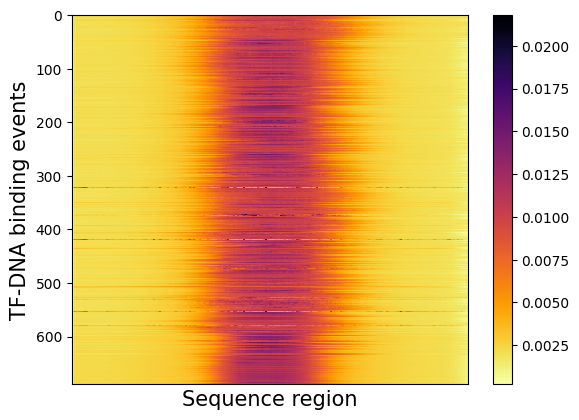

In [6]:
crossattn_landscape = get_crossattn_landscape()
plt.imshow(crossattn_landscape[:, :200], aspect="auto", cmap="inferno_r", interpolation="nearest") # inferno_r, YlGn
plt.colorbar()

plt.ylabel("TF-DNA binding events", fontsize=15)
plt.xlabel("Sequence region", fontsize=15)
plt.xticks([])

plt.savefig(home_dir+f"analysis/figures/crossattn_weights_landscape.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

#### checking out specifics from above plot

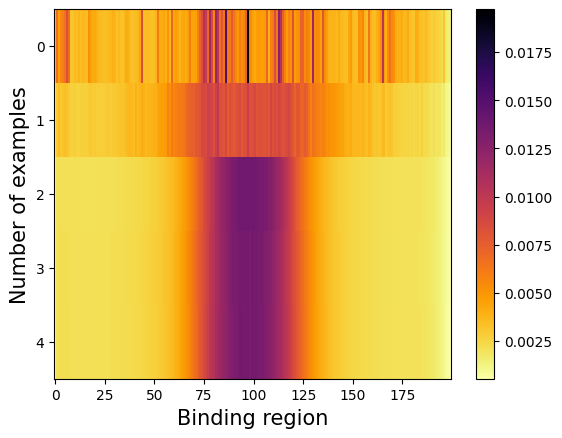

In [25]:
# 323:wgEncodeAwgTfbsSydhGm12878Znf274UniPk, 420:wgEncodeAwgTfbsSydhHelas3Znf274UcdUniPk, 554:wgEncodeAwgTfbsSydhK562Znf274UcdUniPk have different cross-attn weights
plt.imshow(crossattn_landscape[554:554+5, :200], aspect="auto", cmap="inferno_r", interpolation="nearest") # inferno_r, YlGn
plt.colorbar()

plt.ylabel("Number of examples", fontsize=15)
plt.xlabel("Sequence region", fontsize=15)
plt.xticks([])

# plt.savefig(home_dir+f"analysis/figures/crossattn_weights_landscape.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

#### plotting quality specific cross attention weights

In [28]:
from utility.data_utils import get_uniform_peaks_metadata
peaks_metadata_df = get_uniform_peaks_metadata(home_dir)

(690, 18)
Index(['filename', 'project', 'lab', 'composite', 'dataType', 'view', 'cell',
       'treatment', 'antibody', 'control', 'dataVersion', 'dccAccession',
       'controlId', 'quality', 'tableName', 'type', 'md5sum', 'size'],
      dtype='object')


In [42]:
quality = "good" # caution, good
qualitypeaks_metadata_df = peaks_metadata_df[peaks_metadata_df["quality"]==quality]
filenames = qualitypeaks_metadata_df["filename"].tolist()

quality_crossattn_landscape = []
for i, fname in enumerate(filenames):
    label = fname.split(".")[0]
    print(i, label)
    
    crossattn_weights_list = pickle_utils.load(home_dir+f"analysis/weights/690_label_specific/{label}_crossattn_weights_list.pkl")
    # print(len(crossattn_weights_list))
    
    avg_crossattn_w = []
    for i in range(len(crossattn_weights_list)):
        cross_attn_w = crossattn_weights_list[i]
        avg_crossattn_w.append(torch.tensor(np.mean(cross_attn_w, axis=0))) # taking avg over seq tokens
    
    avg_crossattn_w = torch.nn.utils.rnn.pad_sequence(avg_crossattn_w, batch_first=True, padding_value=0).mean(dim=0) # avg over each tf-dna binding event
    # print(avg_crossattn_w.shape)
    
    quality_crossattn_landscape.append(avg_crossattn_w)

    # if label_id==25: break
    
quality_crossattn_landscape = torch.nn.utils.rnn.pad_sequence(quality_crossattn_landscape, batch_first=True, padding_value=0)
quality_crossattn_landscape.shape

0 wgEncodeAwgTfbsBroadDnd41CtcfUniPk
1 wgEncodeAwgTfbsBroadGm12878CtcfUniPk
2 wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk
3 wgEncodeAwgTfbsBroadH1hescChd1a301218aUniPk
4 wgEncodeAwgTfbsBroadH1hescCtcfUniPk
5 wgEncodeAwgTfbsBroadH1hescEzh239875UniPk
6 wgEncodeAwgTfbsBroadH1hescJarid1aab26049UniPk
7 wgEncodeAwgTfbsBroadH1hescRbbp5a300109aUniPk
8 wgEncodeAwgTfbsBroadHelas3CtcfUniPk
9 wgEncodeAwgTfbsBroadHepg2CtcfUniPk
10 wgEncodeAwgTfbsBroadHmecCtcfUniPk
11 wgEncodeAwgTfbsBroadHmecEzh239875UniPk
12 wgEncodeAwgTfbsBroadHsmmCtcfUniPk
13 wgEncodeAwgTfbsBroadHsmmtCtcfUniPk
14 wgEncodeAwgTfbsBroadHsmmtEzh239875UniPk
15 wgEncodeAwgTfbsBroadHuvecCtcfUniPk
16 wgEncodeAwgTfbsBroadHuvecEzh239875UniPk
17 wgEncodeAwgTfbsBroadK562Chd1a301218aUniPk
18 wgEncodeAwgTfbsBroadK562CtcfUniPk
19 wgEncodeAwgTfbsBroadK562Hdac1sc6298UniPk
20 wgEncodeAwgTfbsBroadK562Hdac2a300705aUniPk
21 wgEncodeAwgTfbsBroadK562Hdac6a301341aUniPk
22 wgEncodeAwgTfbsBroadK562Phf8a301772aUniPk
23 wgEncodeAwgTfbsBroadK562Plu1UniPk
24 wg

torch.Size([611, 512])

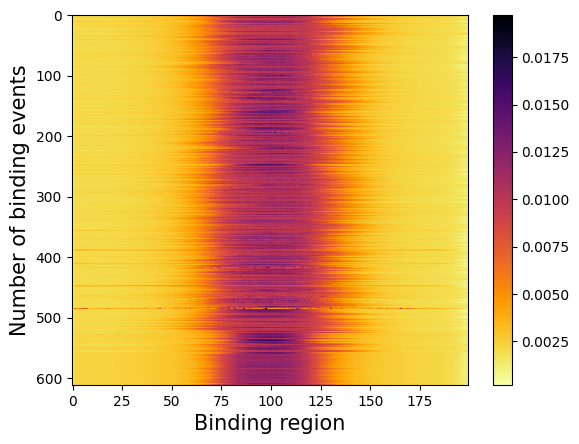

In [43]:
plt.imshow(quality_crossattn_landscape[:, :200], aspect="auto", cmap="inferno_r", interpolation="nearest") # inferno_r, YlGn
plt.colorbar()

plt.ylabel("Number of binding events", fontsize=15)
plt.xlabel("Binding region", fontsize=15)
plt.xticks([])

plt.savefig(home_dir+f"analysis/figures/crossattn_weights_landscape_{quality}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

#### Plotting cross-attn landscape over a single tf-dna binding landscape

In [ ]:
# the following two are from DNABERT
# wgEncodeAwgTfbsUtaA549CtcfUniPk (wgEncodeEH002078), wgEncodeAwgTfbsSydhHelas3Brg1IggmusUniPk (wgEncodeEH000781)

In [2]:
label="wgEncodeAwgTfbsUtaA549CtcfUniPk"
crossattn_weights_list = pickle_utils.load(home_dir+f"analysis/weights/690_label_specific/{label}_crossattn_weights_list.pkl")
print(len(crossattn_weights_list))

# computing avg crossattn weights for a specific tf-dna binding events
import torch
avg_crossattn_w = []
for i in range(len(crossattn_weights_list)):
    cross_attn_w = crossattn_weights_list[i]
    avg_crossattn_w.append(torch.tensor(np.mean(cross_attn_w, axis=0)))
    
avg_crossattn_w = torch.nn.utils.rnn.pad_sequence(avg_crossattn_w, batch_first=True, padding_value=0)
avg_crossattn_w.shape

4797


torch.Size([4797, 248])

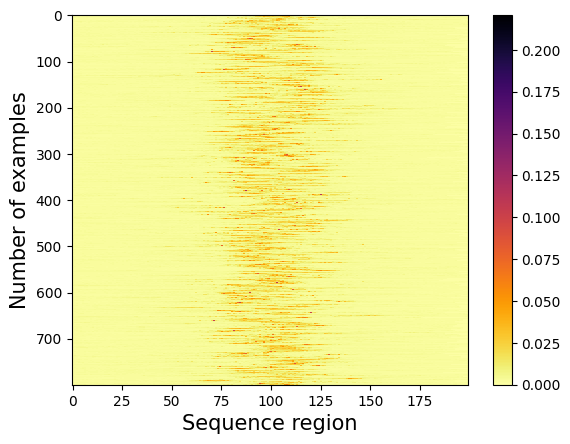

In [3]:
plt.imshow(avg_crossattn_w.numpy()[:800, :200], aspect="auto", cmap="inferno_r", interpolation="nearest") # inferno_r, YlGn
# plt.imshow(np.stack(avg_crossattn_w)[:800], aspect="auto", cmap="inferno_r", interpolation="nearest") # inferno_r, YlGn
plt.colorbar()
plt.xticks([])

plt.ylabel("Number of examples", fontsize=15)
plt.xlabel("Sequence region", fontsize=15)

# plt.savefig(home_dir+f"analysis/figures/label_specific_avg_crossattn_w/{label}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()